<a href="https://colab.research.google.com/github/akshithmandala/Projects/blob/main/SIMHYD_model_for_WRE_lab_21110121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
## Performance metrics
# Nash Sutcliffe efficiency
def NS(s,o):
    #input:
        #s: simulated
        #o: observed
    #output:
        #ns: Nash Sutcliffe efficiency
    return 1 - sum((s-o)**2)/sum((o-np.mean(o))**2)

# Percent Bias
def pc_bias(s,o):

    # input:
    #     s: simulated
    #     o: observed
    # output:
    #     pc_bias: percent bias
    return 100.0*sum(o-s)/sum(o)

# Root Mean Squared Error
def rmse(s,o):

    # input:
    #     s: simulated
    #     o: observed
    # output:
    #     rmse: root mean squared error
    return np.sqrt(np.mean((s-o)**2))


In [ ]:
# import required data
file_name = 'https://raw.githubusercontent.com/pravin2408/WRE_conceptual_model_lab/main/WRE_conceptual_model_lab_data_2000_2018.csv'
data = pd.read_csv(file_name, sep = ',',index_col=['Date'])
data

,Precipitation_mm,PET_mm,Q_mm
Date,,,
2000-01-01,0.0,2.11,0.24
2000-01-02,0.0,2.13,0.24
2000-01-03,0.0,2.13,0.25
2000-01-04,0.0,2.12,0.27
2000-01-05,0.0,2.11,0.26
...,...,...,...
2018-12-27,0.0,1.68,0.69
2018-12-28,0.0,1.97,0.65
2018-12-29,0.0,2.01,0.62


In [ ]:
# warmup period: 2000-01-01 to 2002-12-31
# calibration period: 2003-01-01 to 2013-12-31
# validation period: 2014-01-01 to 2018-12-31
df_warm_cal = data.loc['2000-01-01':'2013-12-31']
df_val = data.loc['2014-01-01':'2018-12-31']
df_warm_cal

,Precipitation_mm,PET_mm,Q_mm
Date,,,
2000-01-01,0.0,2.11,0.24
2000-01-02,0.0,2.13,0.24
2000-01-03,0.0,2.13,0.25
2000-01-04,0.0,2.12,0.27
2000-01-05,0.0,2.11,0.26
...,...,...,...
2013-12-27,0.0,2.14,0.23
2013-12-28,0.0,2.17,0.25
2013-12-29,0.0,2.19,0.25


## **Model inputs**
### Precipitation
### Potential Evapotranspiration

## **Parameters**
### interception store capacity (mm) (INSC): [0.5, 5]
### maximum infiltration loss (mm) (COEFF): [50, 400]
### infiltration loss exponent (SQ): [0, 6]
### soil moisture store capacity (mm) (SMSC): [50, 800]
### constant of proportionality in interflow equation (SUB): [0, 1]
### constant of proportionality in groundwater recharge equation (CRAK): [0, 1]
### baseflow linear recession parameter (K): [0.003, 0.3]
### delay parameter in Muskingum routing (days) (DELAY): [0.5, 10]
### storage weight parameter in Muskingum routing (X_m): [0, 0.5]

In [ ]:
## Calibration
Prec = df_warm_cal['Precipitation_mm']
Q_obs = df_warm_cal['Q_mm']
Evap = df_warm_cal['PET_mm']

### states and parameters initialization ###
# total runoff
U    = np.zeros(len(Prec))
# interception store
IMAX = np.zeros(len(Prec))
# interception amount
INT  = np.zeros(len(Prec))
# interception runoff
INR  = np.zeros(len(Prec))
# infiltration capacity
RMO  = np.zeros(len(Prec))
# direct runoff
IRUN = np.zeros(len(Prec))
# Soil evaporation
ET   = np.zeros(len(Prec))
# Saturation excess runoff and interflow
SRUN = np.zeros(len(Prec))
# Recharge
REC  = np.zeros(len(Prec))
# Infiltration into soil store
SMF  = np.zeros(len(Prec))
# potential evapotranspiration (PET - interception)
POT  = np.zeros(len(Prec))
# baseflow
BAS  = np.zeros(len(Prec))
# soil moisture storage
SMS  = np.zeros(len(Prec))
# ground water storage
GW   = np.zeros(len(Prec))
# actual ET
ET_act = np.zeros(len(Prec))

U_final  = np.zeros(len(Prec))

# define parameters
INSC = 4
COEFF =  200
SQ =  1
SMSC =  600
SUB = 0.5
CRAK = 0.5
K = 0.1
DELAY = 1.5
X_m = 0.1

# initial states
GWt1 = 0
SMSt1 = 0
for t in range(len(Prec)):
    # calculate interception store
    IMAX[t] = min(INSC, Evap[t])
    # then calculate interception
    INT[t] = min(IMAX[t], Prec[t])
    # calculate runoff after interception
    INR[t] = Prec[t] - INT[t]
    # calculate infiltration capacity
    RMO[t] = min(COEFF*np.exp(-SQ*SMSt1/SMSC), INR[t])
    # calculate direct runoff after loading to infiltration capacity
    IRUN[t] = INR[t] - RMO[t]
    # saturation excess runoff and interflow
    SRUN[t] = SUB * SMSt1 / SMSC * RMO[t]
    # calculate recharge
    REC[t] = CRAK * SMSt1 / SMSC * (RMO[t] - SRUN[t])
    # calculate infiltration into soil store
    SMF[t] = RMO[t] - SRUN[t] - REC[t]
    # calculate potential ET (amount of Evap after loses)
    POT[t] = Evap[t] - INT[t]
    # calculate soil evaporation
    ET[t] = min(10 * SMSt1/SMSC, POT[t])
    # calculate soil moisture storage (SMS) overflow
    SMS[t] = SMSt1 + SMF[t] - ET[t]
    # final Evapotranspiration
    ET_act[t] = ET[t] + INT[t]
    # update states of SMS, REC and SMSt1
    if SMS[t] > SMSC:
        REC[t] = REC[t] + SMS[t] - SMSC
        SMS[t] = SMSC
    SMSt1 = SMS[t]
    # calculate baseflow
    BAS[t] = K * GWt1
    # calculate ground water storage
    GW[t] = GWt1 + REC[t] - BAS[t]
    # update state of GWt1
    GWt1 = GW[t]
    # final runoff (effective precipitation) calculation
    U[t] = IRUN[t] + SRUN[t] + BAS[t]
U_final = U #*(A_ds-A_us)/A_ds + Q_us*A_us/A_ds
Q = np.zeros(len(U_final))
# calculate Muskinghum components
if (2*DELAY*X_m < 1) & (2*DELAY*(1-X_m) > 1):
    C0 = (-DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
    C1 = (DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
    C2 = (DELAY*(1-X_m)-0.5)/(DELAY*(1-X_m)+0.5)
else:
    C0 = 0
    C1 = 1
    C2 = 0
# check formal relations
if round(C0 + C1 + C2) != 1.0:
    C0 = 0
    C1 = 1
    C2 = 0
# start transformation
Q[0] = U_final[0]
for t in range(len(U_final)-1):
    Q[t+1] = C0 * U_final[t+1] + C1 * U_final[t] + C2 * Q[t]
    # control Q
    if Q[t+1] < 0: Q[t+1] = 0
df_warm_cal['Q_sim'] = Q

<ipython-input-5-b3e6c7bc16aa>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_warm_cal['Q_sim'] = Q


In [ ]:
print('NSE for calibration:', NS(df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_sim'],df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_mm']))
print('PC_BIAS for calibration:', pc_bias(df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_sim'],df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_mm']))
print('RMSE for calibration:', rmse(df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_sim'],df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_mm']))

NSE for calibration: 0.7536313089599471
PC_BIAS for calibration: 8.615252244064456
RMSE for calibration: 2.3719787749514167


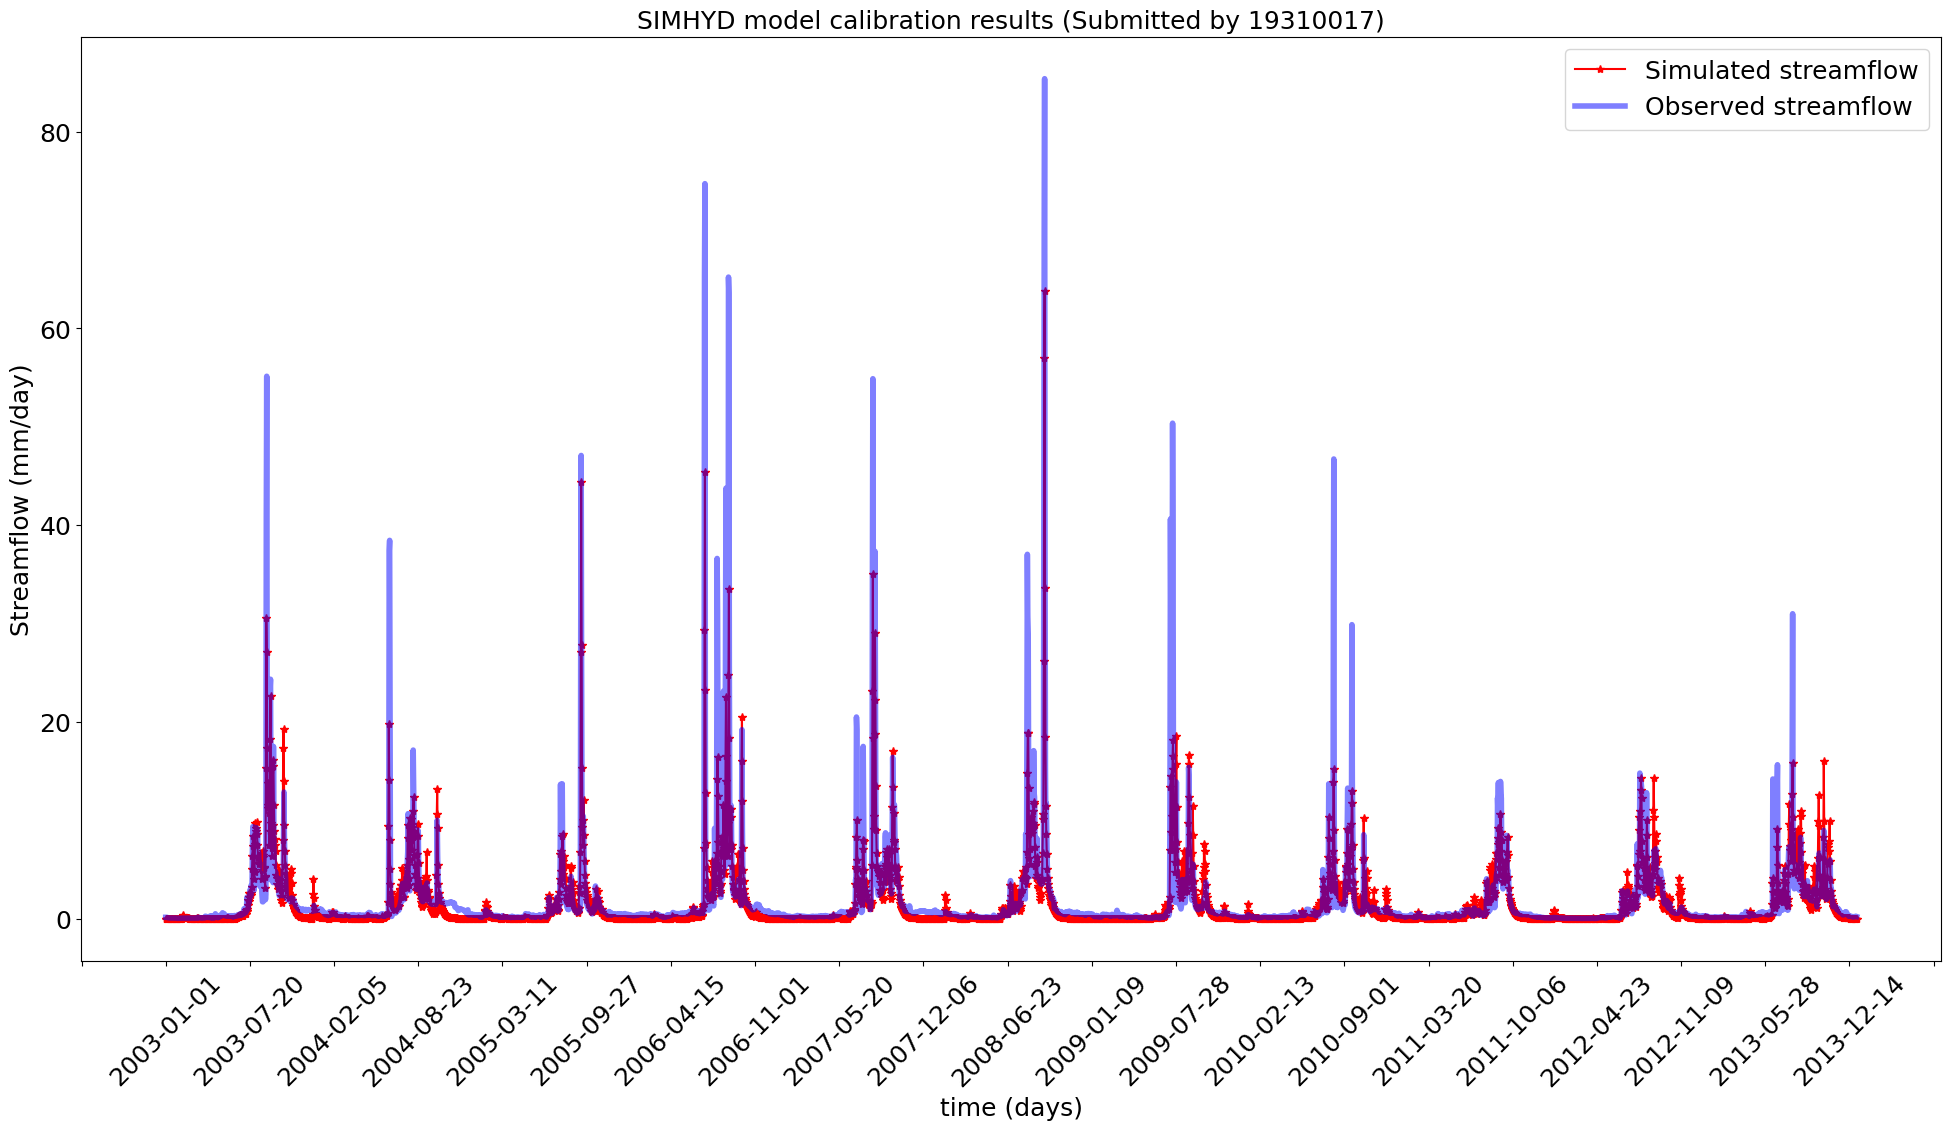

In [ ]:
# Plots for calibration
plt.figure(figsize=(24,12))
plt.plot(df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_sim'], 'r', marker = '*', label='Simulated streamflow')
plt.plot(df_warm_cal.loc['2003-01-01':'2013-12-31']['Q_mm'], 'b', linewidth=4, alpha= 0.5, label='Observed streamflow')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(25))
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.xlabel('time (days)', fontsize=18 )
plt.ylabel('Streamflow (mm/day)', fontsize=18)
plt.title('SIMHYD model calibration results (Submitted by 19310017)', fontsize=18)# Please give your roll number
plt.legend(prop={'size': 18})
plt.savefig('SIMHYD_model_calibration_results_plot_19310017.png')# Please give your roll number

In [ ]:
#files.download('SIMHYD_model_calibration_results_plot_19310017.png') # Please give your roll number

In [ ]:
## Validation
Prec = df_val['Precipitation_mm']
Q_obs = df_val['Q_mm']
Evap = df_val['PET_mm']

# define parameters
INSC = 4
COEFF =  200
SQ =  1
SMSC =  600
SUB = 0.5
CRAK = 0.5
K = 0.1
DELAY = 1.5
X_m = 0.1

# initial states
GWt1 = GW[t]
SMSt1 = SMS[t]
### states and parameters initialization ###
# total runoff
U    = np.zeros(len(Prec))
# interception store
IMAX = np.zeros(len(Prec))
# interception amount
INT  = np.zeros(len(Prec))
# interception runoff
INR  = np.zeros(len(Prec))
# infiltration capacity
RMO  = np.zeros(len(Prec))
# direct runoff
IRUN = np.zeros(len(Prec))
# Soil evaporation
ET   = np.zeros(len(Prec))
# Saturation excess runoff and interflow
SRUN = np.zeros(len(Prec))
# Recharge
REC  = np.zeros(len(Prec))
# Infiltration into soil store
SMF  = np.zeros(len(Prec))
# potential evapotranspiration (PET - interception)
POT  = np.zeros(len(Prec))
# baseflow
BAS  = np.zeros(len(Prec))
# soil moisture storage
SMS  = np.zeros(len(Prec))
# ground water storage
GW   = np.zeros(len(Prec))
# actual ET
ET_act = np.zeros(len(Prec))

U_final  = np.zeros(len(Prec))

for t in range(len(Prec)):
    # calculate interception store
    IMAX[t] = min(INSC, Evap[t])
    # then calculate interception
    INT[t] = min(IMAX[t], Prec[t])
    # calculate runoff after interception
    INR[t] = Prec[t] - INT[t]
    # calculate infiltration capacity
    RMO[t] = min(COEFF*np.exp(-SQ*SMSt1/SMSC), INR[t])
    # calculate direct runoff after loading to infiltration capacity
    IRUN[t] = INR[t] - RMO[t]
    # saturation excess runoff and interflow
    SRUN[t] = SUB * SMSt1 / SMSC * RMO[t]
    # calculate recharge
    REC[t] = CRAK * SMSt1 / SMSC * (RMO[t] - SRUN[t])
    # calculate infiltration into soil store
    SMF[t] = RMO[t] - SRUN[t] - REC[t]
    # calculate potential ET (amount of Evap after loses)
    POT[t] = Evap[t] - INT[t]
    # calculate soil evaporation
    ET[t] = min(10 * SMSt1/SMSC, POT[t])
    # calculate soil moisture storage (SMS) overflow
    SMS[t] = SMSt1 + SMF[t] - ET[t]
    # final Evapotranspiration
    ET_act[t] = ET[t] + INT[t]
    # update states of SMS, REC and SMSt1
    if SMS[t] > SMSC:
        REC[t] = REC[t] + SMS[t] - SMSC
        SMS[t] = SMSC
    SMSt1 = SMS[t]
    # calculate baseflow
    BAS[t] = K * GWt1
    # calculate ground water storage
    GW[t] = GWt1 + REC[t] - BAS[t]
    # update state of GWt1
    GWt1 = GW[t]
    # final runoff (effective precipitation) calculation
    U[t] = IRUN[t] + SRUN[t] + BAS[t]
U_final = U #*(A_ds-A_us)/A_ds + Q_us*A_us/A_ds
Q = np.zeros(len(U_final))
# calculate Muskinghum components
if (2*DELAY*X_m < 1) & (2*DELAY*(1-X_m) > 1):
    C0 = (-DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
    C1 = (DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
    C2 = (DELAY*(1-X_m)-0.5)/(DELAY*(1-X_m)+0.5)
else:
    C0 = 0
    C1 = 1
    C2 = 0
# check formal relations
if round(C0 + C1 + C2) != 1.0:
    C0 = 0
    C1 = 1
    C2 = 0
# start transformation
Q[0] = U_final[0]
for t in range(len(U_final)-1):
    Q[t+1] = C0 * U_final[t+1] + C1 * U_final[t] + C2 * Q[t]
    # control Q
    if Q[t+1] < 0: Q[t+1] = 0
df_val['Q_sim'] = Q

<ipython-input-9-96fc771f93ad>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['Q_sim'] = Q


In [ ]:
print('NSE for validation:', NS(df_val.loc['2014-01-01':'2018-12-31']['Q_sim'],df_val.loc['2014-01-01':'2018-12-31']['Q_mm']))
print('PC_BIAS for validation:', pc_bias(df_val.loc['2014-01-01':'2018-12-31']['Q_sim'],df_val.loc['2014-01-01':'2018-12-31']['Q_mm']))
print('RMSE for validation:', rmse(df_val.loc['2014-01-01':'2018-12-31']['Q_sim'],df_val.loc['2014-01-01':'2018-12-31']['Q_mm']))

NSE for validation: 0.7235685430808665
PC_BIAS for validation: 20.367535332386925
RMSE for validation: 1.837347338416381


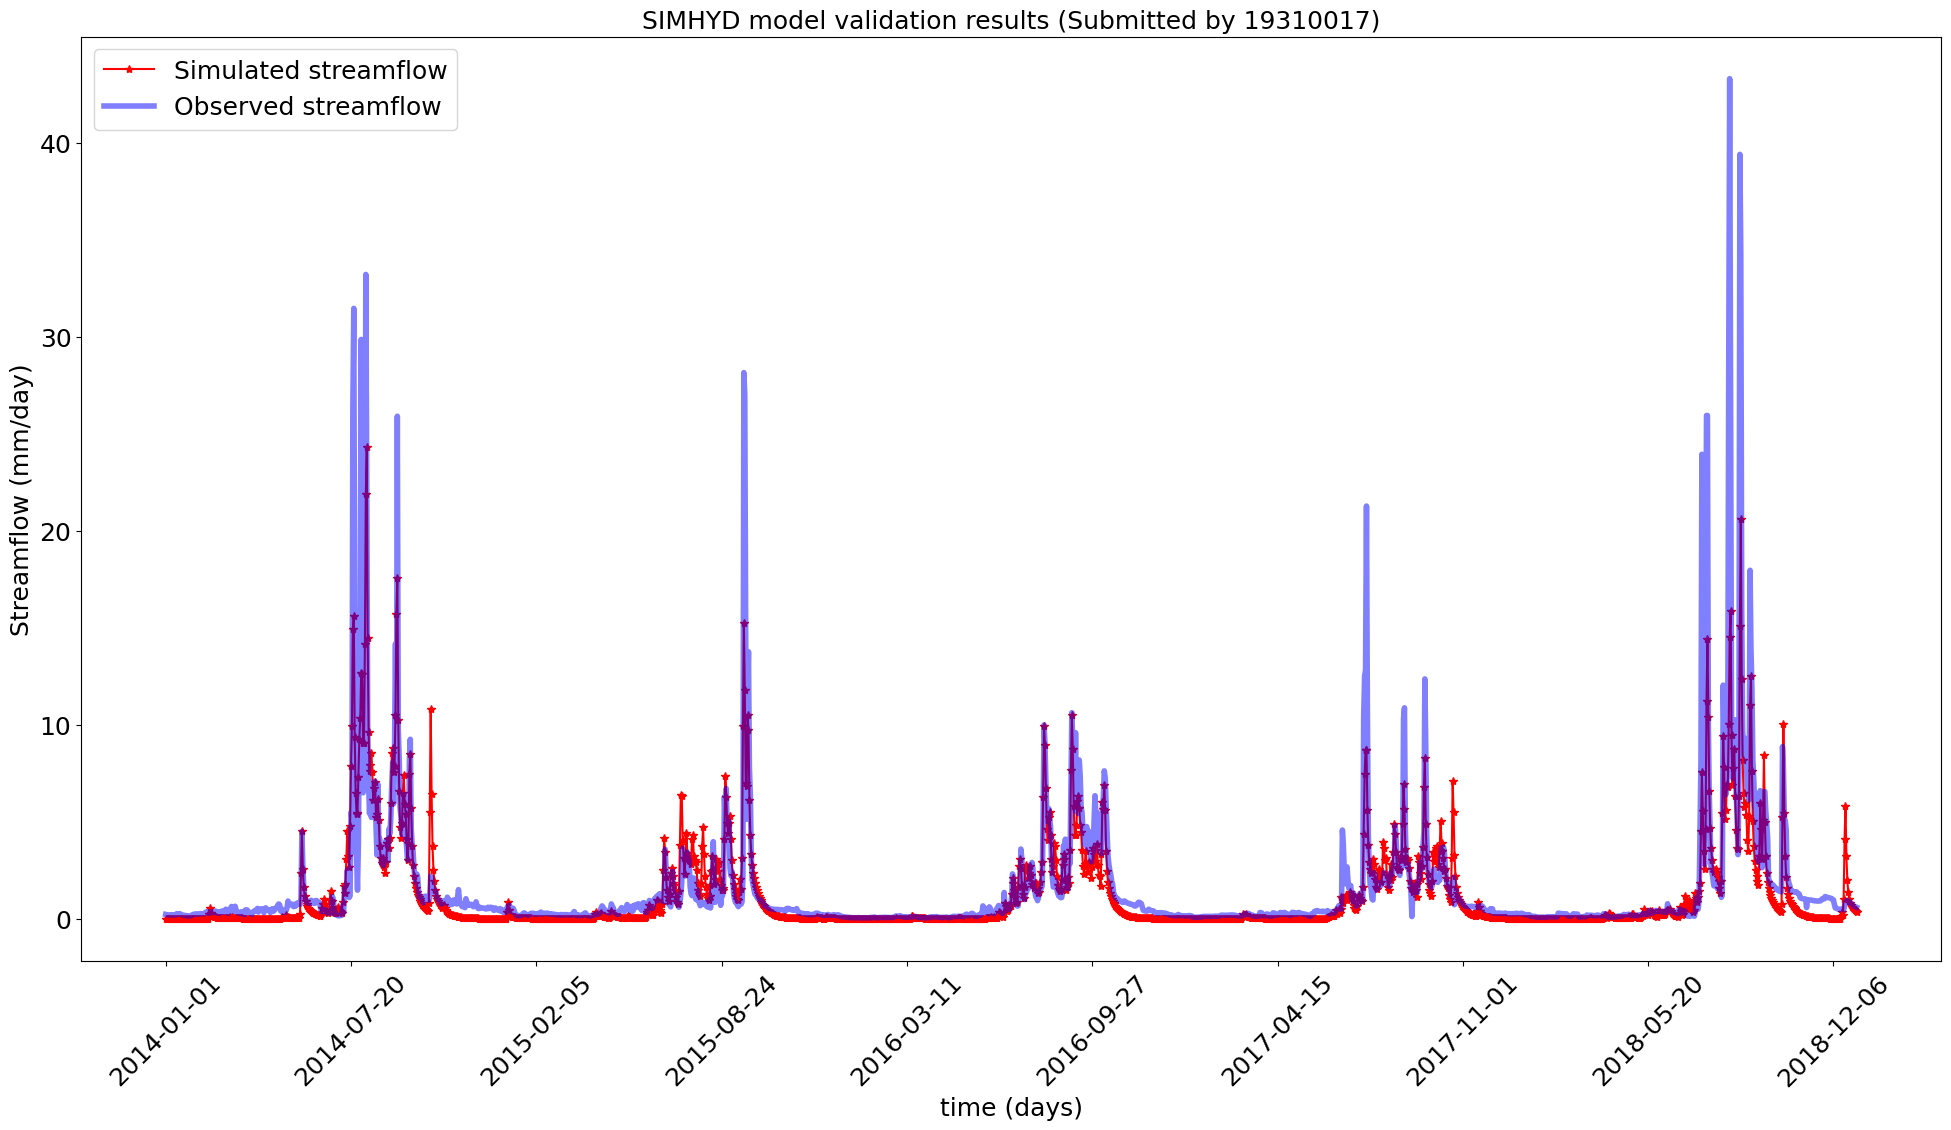

In [ ]:
# Plots for validation
plt.figure(figsize=(24,12))
plt.plot(df_val.loc['2014-01-01':'2018-12-31']['Q_sim'], 'r', marker = '*', label='Simulated streamflow')
plt.plot(df_val.loc['2014-01-01':'2018-12-31']['Q_mm'], 'b', linewidth = 4, alpha= 0.5, label='Observed streamflow')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(11))
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.xlabel('time (days)', fontsize=18 )
plt.ylabel('Streamflow (mm/day)', fontsize=18)
plt.title('SIMHYD model validation results (Submitted by 19310017)', fontsize=18)# Please give your roll number
plt.legend(prop={'size': 18})
plt.savefig('SIMHYD_model_validation_results_plot_19310017.png')# Please give your roll number

In [ ]:
#files.download('SIMHYD_model_validation_results_plot_19310017.png') # Please give your roll number